# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.
 
# Fire up Packages

In [1]:
from __future__ import division
import sklearn
import pandas as pd 
import numpy as np 
import math
import string

## Load and process review dataset

For this assignment, we will use the same subset of the Amazon product review dataset that we used in last assignment. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews.

Load the dataset into a data frame named **products**.

In [2]:
products = pd.read_csv("amazon_baby_subset.csv", encoding="utf8")

In [3]:
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the **important_words**)

Refer to the last assignment for more details.

In [4]:
# The same feature processing (same as the previous assignments)
# ---------------------------------------------------------------
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]


products = products.fillna({'review':''})  # fill in N/A's in the review column

def remove_punctuation(text):
    import string
    return str(text).translate(str.maketrans('','',string.punctuation)) 

# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

Now, let us take a look at what the dataset looks like (**Note:** This may take a few minutes).
As the result, the data frame products should contain one column for each of the 193 important_words. As an example, the column perfect contains a count of the number of times the word prefect occurs in each of the reviews.

In [5]:
products.head()

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use `random_state=42` so that everyone gets the same result.

**Note:** In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters**. Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on a validation set, while evaluation of selected model should always be on a test set.

In [6]:
from sklearn.model_selection import train_test_split

# You can learn a new train_test_split
train_data, validation_data = train_test_split(products, test_size=.2, random_state=42)

print('Training set   : %d data points' % len(train_data))
print('Validation set : %d data points' % len(validation_data))

Training set   : 42457 data points
Validation set : 10615 data points


## Convert DataFrame to NumPy array

Convert train_data and validation_data into multi-dimensional arrays.

We need to extract two arrays feature_matrix_train and sentiment_train from train_data. The 2D array feature_matrix_train would contain the content of the columns given by the list important_words. The 1D array sentiment_train would contain the content of the column sentiment. Do the same for validation_data, producing the arrays feature_matrix_valid and sentiment_valid. The code should be analogous to this cell:

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [7]:
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

We convert both the training and validation sets into NumPy arrays.

**Warning**: This may take a few minutes.

In [8]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

/Users/mac/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
print(sentiment_valid)
print(len(sentiment_valid))

[-1 -1 -1 ...  1  1  1]
10615


In [10]:
print(feature_matrix_valid)
print(feature_matrix_valid.shape)

[[1 0 2 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(10615, 194)


## Building on logistic regression with no L2 penalty assignment

Let us now build on last assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

Probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [86]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def sigmoid(s):
    return 1/(1 + np.exp(s))

def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    ## YOUR CODE HERE
    s = np.dot(feature_matrix, coefficients)
    # Compute P(y_i = +1 | x_i, w) using the link function
    ## YOUR CODE HERE
    predictions = sigmoid(-s)
    return predictions

# Adding  L2 penalty

Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

** Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Note**: As we did in the Regression course, we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [105]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors, feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative -= 2 * l2_penalty * coefficient

    return derivative

** Quiz Question:** In the code above, was the intercept term regularized?

To verify the correctness of the gradient ascent algorithm, we provide a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [77]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

** Quiz Question:** Does the term with L2 regularization increase or decrease $\ell\ell(\mathbf{w})$?

The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.  Fill in the code below to complete this modification.

In [106]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j],
                                                    coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] += step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [116]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29244.40437591
iteration   1: log likelihood of observed labels = -29067.53474361
iteration   2: log likelihood of observed labels = -28897.51368988
iteration   3: log likelihood of observed labels = -28733.73649161
iteration   4: log likelihood of observed labels = -28575.73786328
iteration   5: log likelihood of observed labels = -28423.14188057
iteration   6: log likelihood of observed labels = -28275.63172649
iteration   7: log likelihood of observed labels = -28132.93126246
iteration   8: log likelihood of observed labels = -27994.79366347
iteration   9: log likelihood of observed labels = -27860.99429569
iteration  10: log likelihood of observed labels = -27731.32615689
iteration  11: log likelihood of observed labels = -27605.59687339
iteration  12: log likelihood of observed labels = -27483.62664809
iteration  13: log likelihood of observed labels = -27365.24679399
iteration  14: log likelihood of observed labels = -27250.2986

In [123]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29244.40810772
iteration   1: log likelihood of observed labels = -29067.55649447
iteration   2: log likelihood of observed labels = -28897.56660586
iteration   3: log likelihood of observed labels = -28733.83274333
iteration   4: log likelihood of observed labels = -28575.88875848
iteration   5: log likelihood of observed labels = -28423.35794713
iteration   6: log likelihood of observed labels = -28275.92277848
iteration   7: log likelihood of observed labels = -28133.30645592
iteration   8: log likelihood of observed labels = -27995.26154564
iteration   9: log likelihood of observed labels = -27861.56284942
iteration  10: log likelihood of observed labels = -27732.00284131
iteration  11: log likelihood of observed labels = -27606.38866142
iteration  12: log likelihood of observed labels = -27484.54006097
iteration  13: log likelihood of observed labels = -27366.28793329
iteration  14: log likelihood of observed labels = -27251.4732

In [124]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29244.41370544
iteration   1: log likelihood of observed labels = -29067.58911854
iteration   2: log likelihood of observed labels = -28897.64596917
iteration   3: log likelihood of observed labels = -28733.97709192
iteration   4: log likelihood of observed labels = -28576.11504088
iteration   5: log likelihood of observed labels = -28423.68193920
iteration   6: log likelihood of observed labels = -28276.35918276
iteration   7: log likelihood of observed labels = -28133.86898562
iteration   8: log likelihood of observed labels = -27995.96299865
iteration   9: log likelihood of observed labels = -27862.41517518
iteration  10: log likelihood of observed labels = -27733.01720202
iteration  11: log likelihood of observed labels = -27607.57548839
iteration  12: log likelihood of observed labels = -27485.90910673
iteration  13: log likelihood of observed labels = -27367.84831958
iteration  14: log likelihood of observed labels = -27253.2334

In [125]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29244.49767119
iteration   1: log likelihood of observed labels = -29068.07816268
iteration   2: log likelihood of observed labels = -28898.83488350
iteration   3: log likelihood of observed labels = -28736.13815000
iteration   4: log likelihood of observed labels = -28579.50059343
iteration   5: log likelihood of observed labels = -28428.52633540
iteration   6: log likelihood of observed labels = -28282.88030366
iteration   7: log likelihood of observed labels = -28142.26954265
iteration   8: log likelihood of observed labels = -28006.43167852
iteration   9: log likelihood of observed labels = -27875.12767402
iteration  10: log likelihood of observed labels = -27748.13717157
iteration  11: log likelihood of observed labels = -27625.25540687
iteration  12: log likelihood of observed labels = -27506.29108200
iteration  13: log likelihood of observed labels = -27391.06483049
iteration  14: log likelihood of observed labels = -27279.4080

In [126]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29245.33732871
iteration   1: log likelihood of observed labels = -29072.93599265
iteration   2: log likelihood of observed labels = -28910.56690308
iteration   3: log likelihood of observed labels = -28757.32400270
iteration   4: log likelihood of observed labels = -28612.47620364
iteration   5: log likelihood of observed labels = -28475.40889374
iteration   6: log likelihood of observed labels = -28345.58868083
iteration   7: log likelihood of observed labels = -28222.54178563
iteration   8: log likelihood of observed labels = -28105.84047570
iteration   9: log likelihood of observed labels = -27995.09427168
iteration  10: log likelihood of observed labels = -27889.94401454
iteration  11: log likelihood of observed labels = -27790.05767083
iteration  12: log likelihood of observed labels = -27695.12721326
iteration  13: log likelihood of observed labels = -27604.86618404
iteration  14: log likelihood of observed labels = -27519.0077

In [127]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29337.69965591
iteration   1: log likelihood of observed labels = -29337.57418989
iteration   2: log likelihood of observed labels = -29337.55480223
iteration   3: log likelihood of observed labels = -29337.53986989
iteration   4: log likelihood of observed labels = -29337.52645811
iteration   5: log likelihood of observed labels = -29337.51431963
iteration   6: log likelihood of observed labels = -29337.50332970
iteration   7: log likelihood of observed labels = -29337.49337948
iteration   8: log likelihood of observed labels = -29337.48437059
iteration   9: log likelihood of observed labels = -29337.47621398
iteration  10: log likelihood of observed labels = -29337.46882903
iteration  11: log likelihood of observed labels = -29337.46214273
iteration  12: log likelihood of observed labels = -29337.45608898
iteration  13: log likelihood of observed labels = -29337.45060795
iteration  14: log likelihood of observed labels = -29337.4456

## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

**Quiz Question**. Which of the following is **not** listed in either **positive_words** or **negative_words**?

In [138]:
coefficients_0_penalty_without_intercept = list(coefficients_0_penalty[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients_0_penalty_without_intercept)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)
positive_words = []
for i in range(5):
    positive_words.append(word_coefficient_tuples[:5][i][0])
print(positive_words)
negative_words = []
for i in range(5):
    negative_words.append(word_coefficient_tuples[-5:][i][0])
print(negative_words)

['loves', 'love', 'easy', 'perfect', 'great']
['returned', 'waste', 'return', 'money', 'disappointed']


Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

**Hints**:

First, extract rows corresponding to **positive_words**. Do the same for **negative_words**.

Then plot each of the extracted rows. The x axis should be L2 penalty and the y axis should be the coefficient value.

Use log scale for the x axis, as the L2 penalty values are exponentially spaced.

<img src="coefficient.png">

In [128]:
table = pd.DataFrame(data=[coefficients_0_penalty.flatten(), coefficients_4_penalty.flatten(), coefficients_10_penalty.flatten(), coefficients_1e2_penalty.flatten(), coefficients_1e3_penalty.flatten(), coefficients_1e5_penalty.flatten()], 
                     index=[0, 4, 10, 100.0, 1000.0, 100000.0],
                     columns=['(intercept)'] + important_words)

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*6, '--', lw=1, color='k')
    
    table_positive_words = table[positive_words] 
    table_negative_words = table[negative_words]
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[positive_words[i]].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[negative_words[i]].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

Run the following cell to generate the plot. Use the plot to answer the following quiz question.

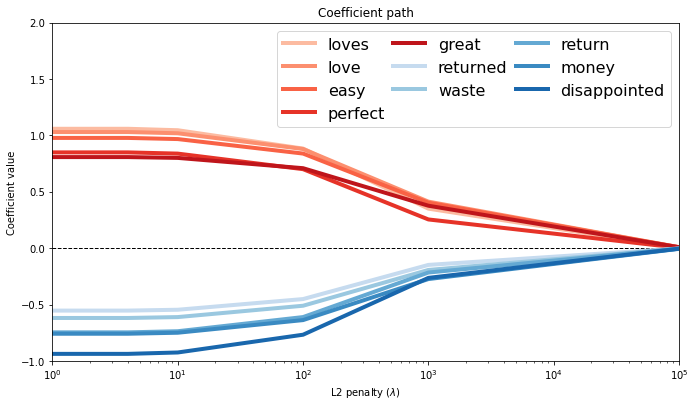

In [140]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as the L2 penalty is increased.

**Quiz Question**: (True/False) The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)

## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.

In [52]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    print(accuracy)

* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **training** data?
* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **validation** data?
* **Quiz Question**: Does the **highest** accuracy on the **training** data imply that the model is the best one?

In [141]:
get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)

0.7844878347504534


In [142]:
get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

0.7844407282662459
0.7843700685399345
0.7825564688979438
0.7741479614668959
0.7219304237228255


In [143]:
get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

0.7806877060763071
0.78078191238813
0.7808761186999529
0.7809703250117758
0.7706076307112577
0.7200188412623646


In [67]:
np.shape(feature_matrix_train.dot(coefficients_0_penalty))

(42457,)

In [75]:
np.shape(sentiment_train.dot(feature_matrix_train))

(194,)